In [1]:
import pymysql
import pandas as pd
import shap as shap
import matplotlib.pyplot as plt


Get Data

In [2]:
# Set up the connection details
hostname = 'localhost'
username = 'root'
password = 'password'
database = 'economics_of_sports'

# Create a connection
connection = pymysql.connect(host=hostname,
                             user=username,
                             password=password,
                             db=database)

# Create a cursor
cursor = connection.cursor()

query = '''
SELECT p.ws_id,
    tmvr.market_value,
    p.name,
    p.nationality,
    p.continent,
    p.heigt,
    IF(LOCATE(' (', p.posistion) = 0, p.posistion, LEFT(p.posistion, LOCATE(' (', p.posistion) - 1)) AS posistion,
    tmvr.player_age,
    p.nationality = l.country AS is_local,
    tmvr.season,
    ws_nl.tournament AS nl_tournament,
    ws_nl.elo_score AS nl_elo_score,
    ws_nl.rating AS nl_rating,
    ws_nl.minutes_played AS nl_minutes_played,
    ws_nl.motm_awards AS nl_motm_awards,
    ws_ec.tournament AS ec_tournament,
    ws_ec.elo_score AS ec_elo_score,
    ws_ec.rating AS ec_rating,
    ws_ec.minutes_played AS ec_minutes_played,
    ws_ec.motm_awards AS ec_motm_awards,
    ws_ntc.tournament AS ntc_tournament,
    ws_ntc.elo_score AS ntc_elo_score,
    ws_ntc.rating AS ntc_rating,
    ws_ntc.minutes_played AS ntc_minutes_played,
    ws_ntc.motm_awards AS ntc_motm_awards,
    ws_nc.tournament AS nc_tournament,
    ws_nc.elo_score AS nc_elo_score,
    ws_nc.rating AS nc_rating,
    ws_nc.minutes_played AS nc_minutes_played,
    ws_nc.motm_awards AS nc_motm_awards
FROM player p
LEFT JOIN tm_market_value_raw tmvr ON p.tm_id = tmvr.tm_player_id
LEFT JOIN team t ON tmvr.team_name = t.name
LEFT JOIN league l ON t.league_id = l.id
LEFT JOIN (
    SELECT * FROM ws_season
    WHERE type = 'National Leagues'
) AS ws_nl ON ws_nl.ws_player_id = p.ws_id AND ws_nl.season = tmvr.season
LEFT JOIN (
    SELECT * FROM ws_season
    WHERE type = 'European Cups'
) AS ws_ec ON ws_ec.ws_player_id = p.ws_id AND ws_ec.season = tmvr.season
LEFT JOIN (
    SELECT * FROM ws_season
    WHERE type = 'National Team Cups'
) AS ws_ntc ON ws_ntc.ws_player_id = p.ws_id AND ws_ntc.season = tmvr.season
LEFT JOIN (
    SELECT * FROM ws_season
    WHERE type = 'National Cups'
) AS ws_nc ON ws_nc.ws_player_id = p.ws_id AND ws_nc.season = tmvr.season
WHERE ws_nl.season IS NOT NULL
GROUP BY p.ws_id, tmvr.market_value, p.name, p.nationality, p.continent, p.heigt, posistion, tmvr.player_age, is_local, tmvr.season, nl_tournament, nl_elo_score, nl_rating, nl_minutes_played, nl_motm_awards, ec_tournament, ec_elo_score, ec_rating, ec_minutes_played, ec_motm_awards, ntc_tournament, ntc_elo_score, ntc_rating, ntc_minutes_played, ntc_motm_awards, nc_tournament, nc_elo_score, nc_rating, nc_minutes_played, nc_motm_awards
ORDER BY name, tmvr.season;
'''

# Execute a query to select all from the "employees" table
cursor.execute(query=query)

# Fetch all the rows
rows = cursor.fetchall()

# Get column names
column_names = [i[0] for i in cursor.description]

# Convert the data to a pandas DataFrame
df = pd.DataFrame(rows, columns=column_names)

# Close the cursor and connection
cursor.close()
connection.close()

Clean up data and split

In [3]:
targets=df.market_value
df[["nl_rating"]] = df[["nl_rating"]].apply(pd.to_numeric)
df[["ec_rating"]] = df[["ec_rating"]].apply(pd.to_numeric)
df[["ntc_rating"]] = df[["ntc_rating"]].apply(pd.to_numeric)
df[["nc_rating"]] = df[["nc_rating"]].apply(pd.to_numeric)
inputs=df.drop(['ws_id', 'name','nl_tournament', 'ec_tournament', 'ntc_tournament', 'nc_tournament', 'market_value'],axis='columns')

inputs = pd.get_dummies(inputs)

from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=3)

Create train model

In [4]:
'''from xgboost.sklearn import XGBRegressor
reg = XGBRegressor()
reg.fit(X_train, y_train)
train_sq = reg.score(X_train, y_train)
r_sq = reg.score(X_test, y_test)
print(r_sq)'''

'from xgboost.sklearn import XGBRegressor\nreg = XGBRegressor()\nreg.fit(X_train, y_train)\ntrain_sq = reg.score(X_train, y_train)\nr_sq = reg.score(X_test, y_test)\nprint(r_sq)'

Analyse model

In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import make_scorer, r2_score

# Define the parameter grid for the XGBRegressor
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [1, 2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.9],
    'subsample': [0.2, 0.5, 0.7, 1.0],
    'colsample_bytree': [0.2, 0.5, 0.7, 1.0],
}

# Create a regressor object
reg = XGBRegressor()

# Define scoring function
scorer = make_scorer(r2_score)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data.
grid_search.fit(X_train, y_train)

# Get the optimal parameters
best_params = grid_search.best_params_

# Print the optimal parameters
print(f"Best parameters: {best_params}")

# Use the model with the optimal parameters to make predictions
best_model = grid_search.best_estimator_
train_sq = best_model.score(X_train, y_train)
test_sq = best_model.score(X_test, y_test)

print(f"Train R^2: {train_sq}")
print(f"Test R^2: {test_sq}")


Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.7}
Train R^2: 0.9860040484845144
Test R^2: 0.81152366902168


In [6]:
from xgboost.sklearn import XGBRegressor
reg = XGBRegressor(**best_params)
reg.fit(X_train, y_train)
train_sq = reg.score(X_train, y_train)
r_sq = reg.score(X_test, y_test)
print(r_sq)

0.81152366902168


Feature ec_motm_awards: 0.0845751017332077
Feature ec_elo_score: 0.061088014394044876
Feature ntc_motm_awards: 0.04974140599370003
Feature nationality_Ukraine: 0.0423317514359951
Feature ec_minutes_played: 0.039374176412820816
Feature posistion_Defender: 0.034268926829099655
Feature nl_elo_score: 0.02882508374750614
Feature ntc_elo_score: 0.028427373617887497
Feature season: 0.027790803462266922
Feature nationality_Egypt: 0.024601561948657036
Feature nl_rating: 0.022778481245040894
Feature nl_motm_awards: 0.022386329248547554
Feature posistion_Attacking Midfielder: 0.020665790885686874
Feature ntc_rating: 0.01876400224864483
Feature nationality_Croatia: 0.018762921914458275
Feature player_age: 0.018309548497200012
Feature nationality_Portugal: 0.017341408878564835
Feature nationality_Austria: 0.016207870095968246
Feature ntc_minutes_played: 0.01510155014693737
Feature ec_rating: 0.015035746619105339
Feature nationality_Argentina: 0.014739149250090122
Feature nc_minutes_played: 0.014197

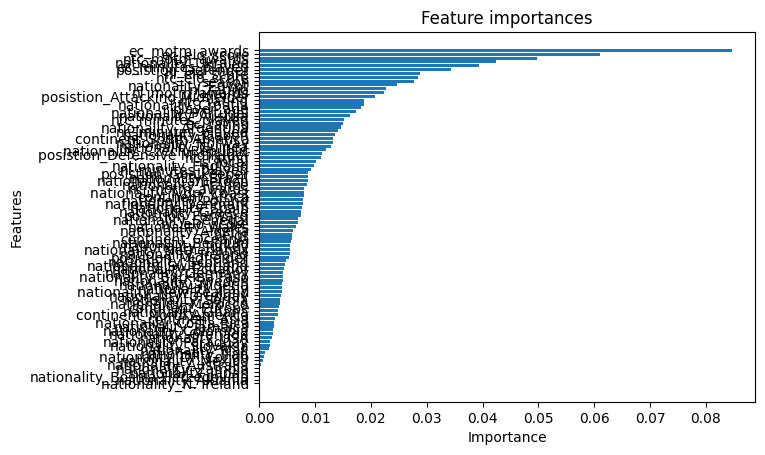

In [7]:
# Get feature importances
importances = reg.feature_importances_

# Create a pandas DataFrame with feature importances
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})

# Sort the DataFrame by importances
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Summarize feature importances
for i, row in importance_df.iterrows():
    print(f'Feature {row["Feature"]}: {row["Importance"]}')

# Plot feature importances
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important at the top
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


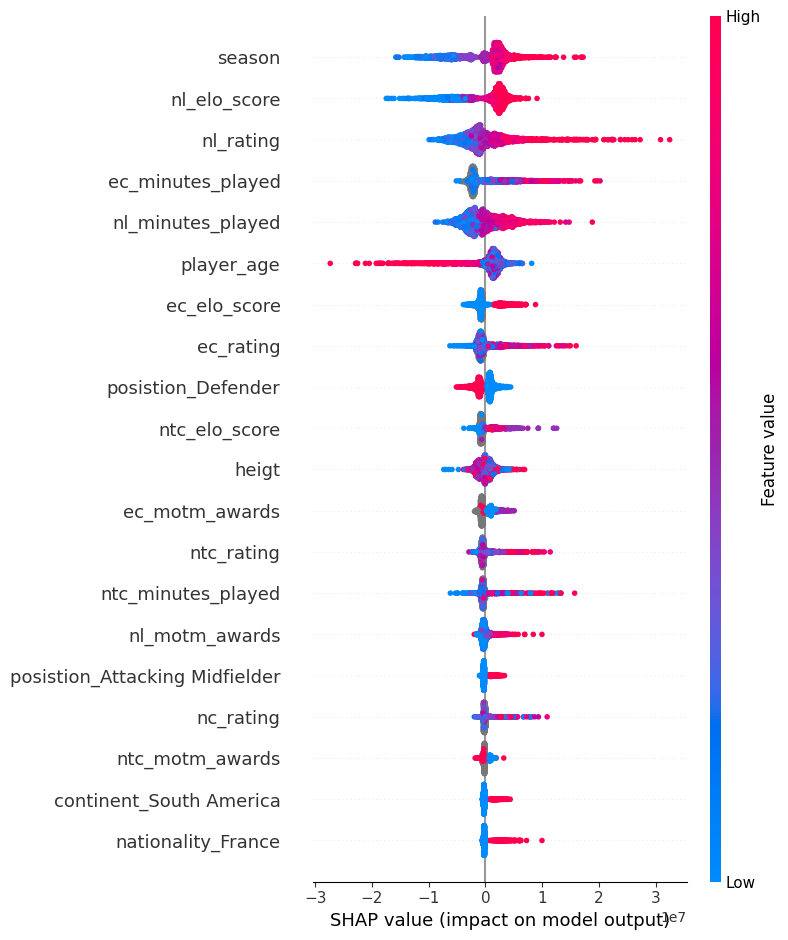

In [8]:
import xgboost
import shap
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)


In [9]:
Compare teams






SyntaxError: invalid syntax (1046302372.py, line 1)